# **Aprendizaje en Conjunto y Random Forest**

**Resumen:** En este capítulo exploraremos distintas técnicas de ensamblaje, incluyendo clasificadores por votación (hard y soft voting), bagging, pasting, bosques aleatorios, boosting (AdaBoost y Gradient Boosting) y stacking. Se muestran ejemplos prácticos y se explican los conceptos clave.

# Clasificadores por Votación (Voting Classifiers)

En esta sección se muestra primero cómo simular el comportamiento de la ley de los grandes números con lanzamientos de moneda, y luego se construye un clasificador por votación que combina distintos modelos.

**Resumen:** Se ejemplifica la convergencia de la proporción de “caras” en lanzamientos de moneda y se muestra cómo combinar un clasificador de Regresión Logística, un Bosque Aleatorio y un SVM en un VotingClassifier.

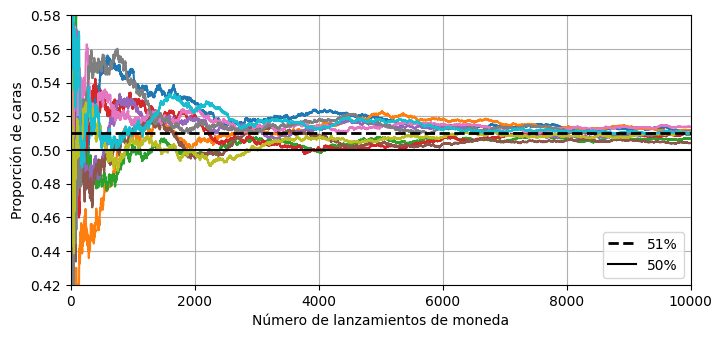

In [15]:
# Código extra – esta celda genera y guarda la Figura 7–3
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Número de lanzamientos de moneda")
plt.ylabel("Proporción de caras")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

A continuación, se construye un VotingClassifier combinando tres estimadores: Regresión Logística, Bosque Aleatorio y SVM. Primero se entrena cada uno por separado y se evalúa su desempeño.

In [16]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Generamos un dataset tipo "moons" (dos lunas) con ruido
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Definimos el VotingClassifier con tres estimadores
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [17]:
# Evaluamos el desempeño de cada clasificador individualmente
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [18]:
# Ejemplo de predicción con el VotingClassifier sobre una instancia
print("Predicción VotingClassifier:", voting_clf.predict(X_test[:1]))

Predicción VotingClassifier: [1]


In [19]:
# También mostramos las predicciones de cada estimador individual
print("Predicciones individuales:", [clf.predict(X_test[:1]) for clf in voting_clf.estimators_])

Predicciones individuales: [array([1]), array([1]), array([0])]


In [20]:
# Evaluamos el puntaje global del VotingClassifier
print("Puntaje VotingClassifier (hard voting):", voting_clf.score(X_test, y_test))

Puntaje VotingClassifier (hard voting): 0.912


Ahora probamos con _votación suave_ (soft voting), que utiliza las probabilidades de clase en lugar de las etiquetas.  

**Nota:** Para que SVC pueda estimar probabilidades, se debe habilitar el parámetro `probability=True`.

In [21]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
print("Puntaje VotingClassifier (soft voting):", voting_clf.score(X_test, y_test))

Puntaje VotingClassifier (soft voting): 0.92


# Bagging y Pasting

En esta sección se utiliza la técnica de _bagging_ (ensamblaje mediante muestreo con reemplazo) para entrenar varios árboles de decisión y combinar sus predicciones.

**Resumen:** Se entrena un BaggingClassifier compuesto por 500 árboles de decisión y se visualizan las fronteras de decisión comparando un árbol individual y el ensamblaje.

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Se crea un BaggingClassifier con 500 estimadores, usando 100 muestras por árbol
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

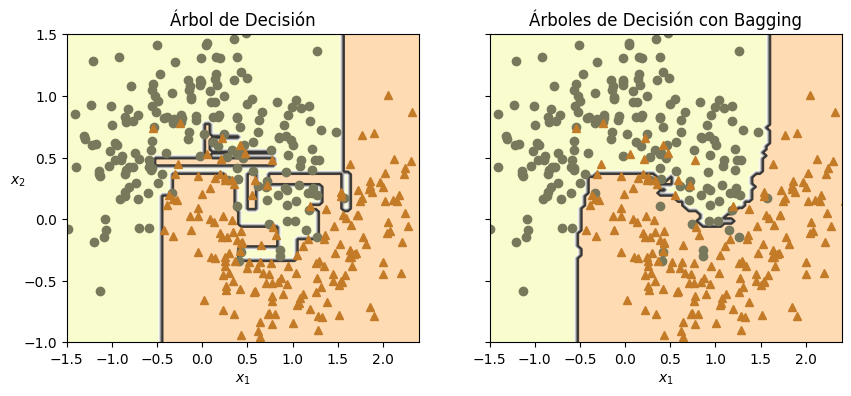

In [23]:
# Código extra – esta celda genera y guarda la Figura 7–5
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# Entrenamos un árbol de decisión simple para comparación
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Árbol de Decisión")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Árboles de Decisión con Bagging")
plt.ylabel("")
plt.show()

## Evaluación Out-of-Bag (OOB)

Con _bagging_ es posible evaluar el desempeño de cada árbol en los ejemplos que no fueron usados para su entrenamiento (Out-of-Bag). Esto permite obtener una estimación casi no sesgada sin necesidad de usar un conjunto de validación adicional.

In [24]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
print("Puntaje OOB:", bag_clf.oob_score_)

Puntaje OOB: 0.896


In [25]:
# Se muestran las probabilidades OOB para las tres primeras instancias
print("OOB decision function (primeras 3 instancias):", bag_clf.oob_decision_function_[:3])

OOB decision function (primeras 3 instancias): [[0.32352941 0.67647059]
 [0.3375     0.6625    ]
 [1.         0.        ]]


In [26]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))

Precisión en el conjunto de prueba: 0.92


**Concepto importante:**  
Al muestrear con reemplazo de un conjunto de tamaño _m_, la probabilidad de que una instancia no sea seleccionada en una extracción es 1 – 1/_m_. Si se extraen _m_ muestras, la probabilidad de que una instancia nunca se seleccione es aproximadamente exp(–1) ≈ 0.37, lo que significa que cerca del 63% de las instancias se usan en cada estimador.

In [27]:
# Código extra – muestra cómo se calcula la probabilidad del 63%
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Bosques Aleatorios (Random Forests)

Un Bosque Aleatorio es un bagging ensemble con árboles de decisión en el que se introduce aleatoriedad adicional al considerar solo un subconjunto aleatorio de características en cada división.

**Resumen:** Se entrena un RandomForestClassifier y se compara su comportamiento con un BaggingClassifier configurado de forma equivalente. Se verifica que, en muchos casos, ambos producen las mismas predicciones.

In [28]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Un Bosque Aleatorio es equivalente a un bagging de árboles de decisión con algunas restricciones adicionales:

In [29]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [30]:
# Código extra – se verifica que las predicciones son idénticas
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print("¿Predicciones idénticas?", np.all(y_pred_bag == y_pred_rf))

¿Predicciones idénticas? True


## Importancia de las Características (Feature Importance)

Los Bosques Aleatorios pueden proporcionar una medida de la importancia de cada característica, lo que es útil para entender el modelo y para realizar selección de variables.

In [31]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


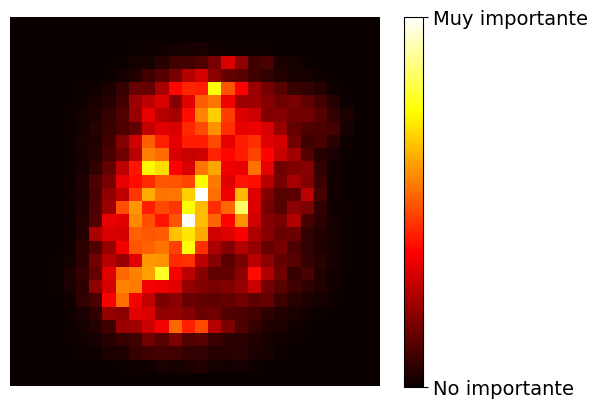

In [32]:
# Código extra – esta celda genera y guarda la Figura 7–6
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['No importante', 'Muy importante'], fontsize=14)
plt.axis("off")
plt.show()

# Boosting

En esta sección se abordan dos técnicas de boosting: AdaBoost y Gradient Boosting.

## AdaBoost

Con AdaBoost se entrenan secuencialmente modelos (por ejemplo, SVMs) y se van ponderando los ejemplos mal clasificados para enfocarse en ellos.

**Resumen:** Se muestra cómo ajustar los pesos de las muestras y se generan gráficas que ilustran la evolución de las fronteras de decisión a medida que se agregan nuevos clasificadores.

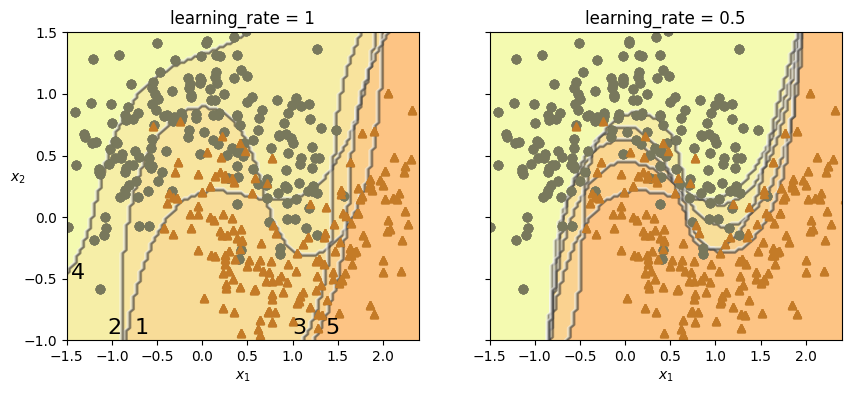

In [33]:
# Código extra – esta celda genera y guarda la Figura 7–8
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # Ecuación 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # Ecuación 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # Ecuación 7-3
        sample_weights /= sample_weights.sum()  # Paso de normalización

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

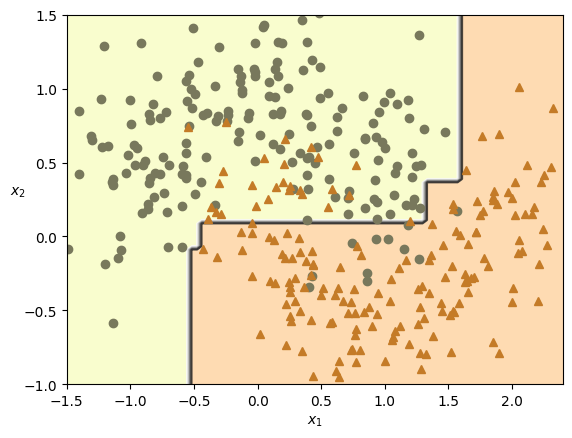

In [35]:
# Código extra – para visualizar la frontera de decisión del AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)
plt.show()

## Gradient Boosting

En Gradient Boosting se ajusta un modelo en los residuos del modelo anterior. Se muestra un ejemplo con un conjunto de datos cuadrático.

**Resumen:** Se entrena un primer árbol de regresión, luego se calcula el residuo (error) y se entrena un segundo árbol sobre ese residuo, y así sucesivamente. Finalmente se suman las predicciones para obtener la predicción final del ensemble.

In [36]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + ruido gaussiano

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Se entrena un segundo árbol sobre los errores residuales del primer modelo:

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [38]:
# Se entrena un tercer árbol sobre los residuos del segundo modelo:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [39]:
# Para tres ejemplos nuevos, se suma la predicción de los tres árboles:
X_new = np.array([[-0.4], [0.], [0.5]])
print("Predicción ensemble (suma de h1, h2 y h3):", sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)))

Predicción ensemble (suma de h1, h2 y h3): [0.49484029 0.04021166 0.75026781]


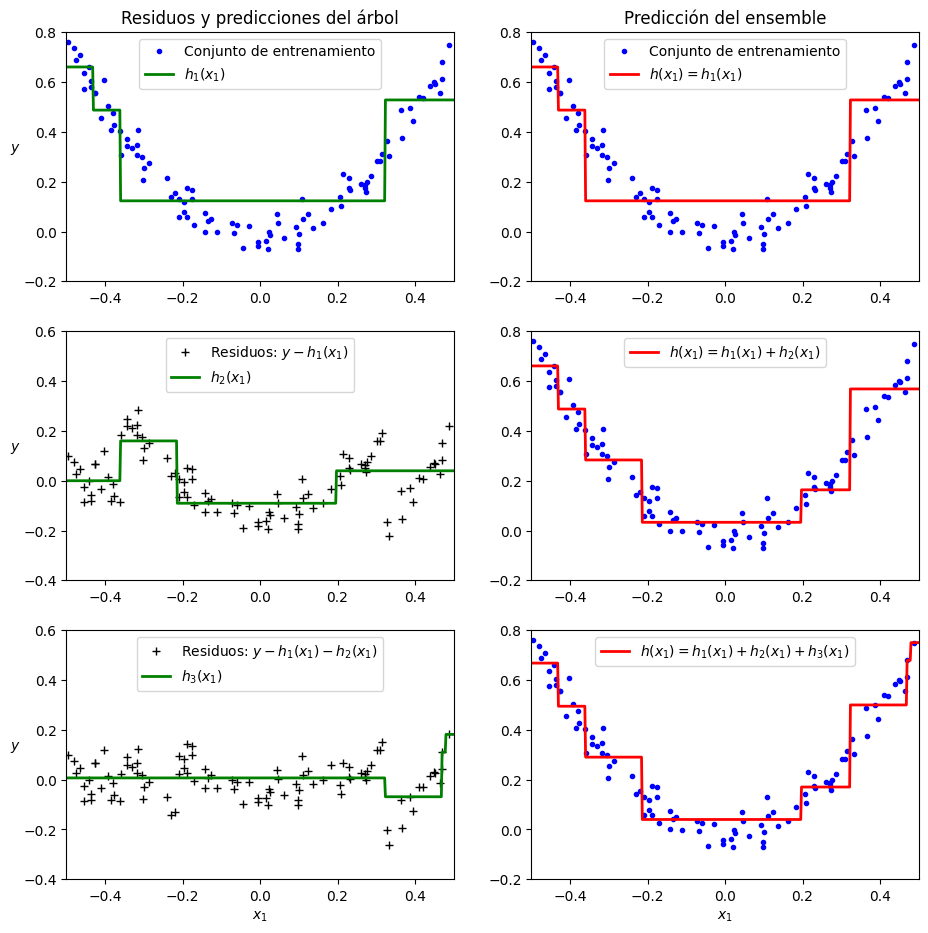

In [40]:
# Código extra – esta celda genera y guarda la Figura 7–9
def plot_predictions(regresores, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regresores)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Conjunto de entrenamiento")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuos y predicciones del árbol")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Conjunto de entrenamiento")
plt.title("Predicción del ensemble")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuos: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuos: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

Ahora entrenamos un _GradientBoostingRegressor_ usando scikit-learn, tanto con un conjunto pequeño de estimadores como con uno mejor ajustado.

**Resumen:** Se muestra la diferencia en el número de estimadores y la tasa de aprendizaje, que son hiperparámetros clave para evitar el sobreajuste en gradient boosting.

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [42]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [43]:
print("Número de estimadores en gbrt_best:", gbrt_best.n_estimators_)

Número de estimadores en gbrt_best: 92


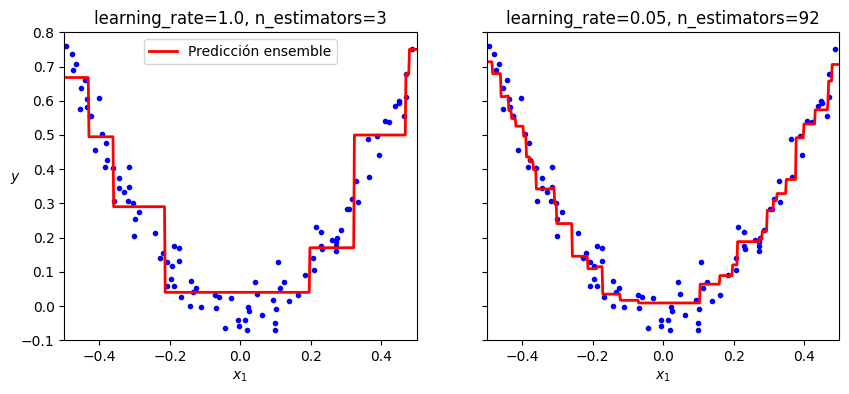

In [44]:
# Código extra – esta celda genera y guarda la Figura 7–10
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Predicción ensemble")
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

plt.show()

In [45]:
# Código extra – en este capítulo se muestra cómo cargar el conjunto de datos Housing (se presenta con más detalle en el capítulo 2)
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request
from pathlib import Path

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder 

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

c:\Users\anoni\AppData\Local\pypoetry\Cache\virtualenvs\bootcamp-ds-R6wI3bVx-py3.11\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [47]:
# Código extra – se evalúa el RMSE del modelo hgb_reg usando validación cruzada
from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
print(pd.Series(hgb_rmses).describe())

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64


# Stacking

En stacking se entrenan varios modelos base y sus predicciones se utilizan como entradas para un "blender" o meta-modelo final.

**Resumen:** Se construye un StackingClassifier que combina las predicciones de distintos estimadores y utiliza un RandomForestClassifier como modelo final.

In [48]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # número de folds en validación cruzada
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [49]:
print("Puntaje StackingClassifier:", stacking_clf.score(X_test, y_test))

Puntaje StackingClassifier: 0.928


# Soluciones a los Ejercicios

## Ejercicios 1 a 7

1. Si has entrenado cinco modelos diferentes y todos logran una precisión del 95%, combinarlos en un ensemble por votación suele dar mejores resultados, sobre todo si los modelos son muy distintos.
2. Un clasificador por votación "hard" cuenta los votos de cada modelo y elige la clase mayoritaria; el "soft" promedia las probabilidades de cada clase, dándole más peso a las predicciones con alta confianza.
3. El bagging y el pasting pueden entrenarse en paralelo ya que cada predictor es independiente, a diferencia del boosting, donde los modelos se entrenan secuencialmente.
4. La evaluación out-of-bag permite estimar el desempeño sin separar un conjunto de validación, aprovechando así más datos para entrenar.
5. En un Bosque Aleatorio se selecciona un subconjunto aleatorio de características en cada división, lo que ayuda a reducir la correlación entre los árboles y a mejorar la generalización.
6. Si AdaBoost presenta underfitting, se puede aumentar el número de estimadores, reducir la regularización del estimador base o aumentar ligeramente la tasa de aprendizaje.
7. Si Gradient Boosting sobreajusta, se recomienda disminuir la tasa de aprendizaje o utilizar early stopping para determinar el número óptimo de predictores.

## Ejercicio 8. Clasificador por Votación

**Enunciado:** _Carga el conjunto de datos MNIST y divídelo en un conjunto de entrenamiento (50.000 instancias), validación (10.000) y prueba (10.000)._

Dado que el dataset MNIST ya está dividido (60.000 para entrenamiento y 10.000 para prueba), solo separamos los primeros 50.000 para entrenamiento, los siguientes 10.000 para validación y los últimos 10.000 para prueba.

In [50]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

**Enunciado:** _Luego, entrena varios clasificadores, como un Random Forest, un Extra-Trees y un SVM._

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

**Nota:** En `LinearSVC` se establece explícitamente el parámetro `dual=True` para mantener la consistencia en la salida (consulta la documentación para más detalles).

In [52]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [53]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Entrenando:", estimator)
    estimator.fit(X_train, y_train)

Entrenando: RandomForestClassifier(random_state=42)
Entrenando: ExtraTreesClassifier(random_state=42)
Entrenando: LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Entrenando: MLPClassifier(random_state=42)


In [54]:
print("Puntajes en el conjunto de validación:")
print([estimator.score(X_valid, y_valid) for estimator in estimators])

Puntajes en el conjunto de validación:
[0.9736, 0.9743, 0.8662, 0.9646]


Se observa que el SVM lineal rinde peor que los otros clasificadores; sin embargo, se mantendrá en el ensemble para ver su efecto en la votación.

**Enunciado:** _Combina los clasificadores en un ensemble (VotingClassifier) y evalúa su desempeño en el conjunto de validación. Prueba con votación suave y dura._

In [55]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

print("Puntaje VotingClassifier (validación):", voting_clf.score(X_valid, y_valid))

Puntaje VotingClassifier (validación): 0.9755


**Aviso:**  
El VotingClassifier hace clones de cada clasificador y utiliza índices de clase para entrenarlos. Si es necesario, se puede utilizar un LabelEncoder para convertir las clases, pero en el caso de MNIST basta con convertir a enteros.

In [56]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)
# En MNIST, los dígitos ya coinciden con los índices, así que:
y_valid_encoded = y_valid.astype(np.int64)

Se evalúan los clones de los clasificadores:

In [57]:
print("Puntajes de los clasificadores clonados en VotingClassifier:")
print([estimator.score(X_valid, y_valid_encoded) for estimator in voting_clf.estimators_])

Puntajes de los clasificadores clonados en VotingClassifier:
[0.9736, 0.9743, 0.8662, 0.9646]


Se procede a eliminar el SVM, que afecta negativamente al desempeño. Esto se hace ajustando los parámetros del VotingClassifier.

In [58]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

Aunque la lista de estimadores se actualiza, la lista de entrenados no lo hace, por lo que se elimina el estimador SVM de ambas listas:

In [59]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

Se vuelve a evaluar el VotingClassifier:

In [60]:
print("Puntaje VotingClassifier (sin SVM):", voting_clf.score(X_valid, y_valid))

Puntaje VotingClassifier (sin SVM): 0.9763


Ahora se prueba con votación suave. Basta con cambiar el atributo `voting`:

In [61]:
voting_clf.voting = "soft"
print("Puntaje VotingClassifier (soft voting):", voting_clf.score(X_valid, y_valid))

Puntaje VotingClassifier (soft voting): 0.97


En este caso, la votación dura (hard voting) rinde mejor. Se evalúa en el conjunto de prueba y se comparan los puntajes de los clasificadores individuales.

In [62]:
voting_clf.voting = "hard"
print("Puntaje VotingClassifier en el conjunto de prueba:", voting_clf.score(X_test, y_test))
print("Puntajes individuales en el conjunto de prueba:",
      [estimator.score(X_test, y_test.astype(np.int64)) for estimator in voting_clf.estimators_])
#
# Se observa que el VotingClassifier reduce la tasa de error del mejor modelo de aproximadamente 3% a 2.7%, es decir, se producen cerca de un 10% menos de errores.

Puntaje VotingClassifier en el conjunto de prueba: 0.9739
Puntajes individuales en el conjunto de prueba: [0.968, 0.9703, 0.9644]


## Ejercicio 9. Ensemble de Stacking

**Enunciado:** _Utiliza los clasificadores individuales para hacer predicciones en el conjunto de validación y crea un nuevo conjunto de entrenamiento, donde cada instancia es un vector con las predicciones de cada modelo y la etiqueta es la clase original. Entrena un clasificador (blender) sobre este nuevo conjunto._

Se recogen las predicciones de cada modelo en el conjunto de validación:

In [63]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

print("Predicciones del conjunto de validación (stacking):")
print(X_valid_predictions)

Predicciones del conjunto de validación (stacking):
[['3' '3' '3' '3']
 ['8' '8' '8' '8']
 ['6' '6' '6' '6']
 ...
 ['5' '5' '5' '5']
 ['6' '6' '6' '6']
 ['8' '8' '8' '8']]


In [64]:
# Se entrena un "blender" usando un RandomForestClassifier
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

print("Puntaje OOB del blender:", rnd_forest_blender.oob_score_)

Puntaje OOB del blender: 0.9726


_En adelante, se evalúa el ensemble de stacking en el conjunto de prueba: para cada imagen se recogen las predicciones de cada clasificador y se alimenta el blender para obtener la predicción final._

In [65]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

y_pred = rnd_forest_blender.predict(X_test_predictions)
print("Precisión del ensemble de stacking:", accuracy_score(y_test, y_pred))

Precisión del ensemble de stacking: 0.9692


En este ejemplo el ensemble de stacking no supera el desempeño del VotingClassifier.

**Ejercicio adicional:** _Vuelve a intentarlo utilizando StackingClassifier y compáralo con el VotingClassifier._

Como el StackingClassifier de scikit-learn usa validación cruzada, no es necesario disponer de un conjunto de validación separado. Se unen los conjuntos de entrenamiento y validación:

In [66]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Se crea y entrena el StackingClassifier sobre el conjunto completo de entrenamiento.

**Advertencia:** La siguiente celda puede tardar entre 15 y 30 minutos en ejecutarse, ya que entrena los clasificadores con 5 folds de validación cruzada (es decir, 25 modelos en total).

In [4]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

NameError: name 'StackingClassifier' is not defined

In [5]:
print("Puntaje StackingClassifier en el conjunto de prueba:", stack_clf.score(X_test, y_test))

NameError: name 'stack_clf' is not defined

**Resumen final:**  
El StackingClassifier obtuvo un desempeño significativamente mejor que la implementación de stacking manual. Esto se debe a dos factores principales:

* Al disponer de más datos (se reubicó el conjunto de validación), el modelo final se entrenó con más información.
* El StackingClassifier utiliza `predict_proba()` o `decision_function()` (cuando están disponibles), proporcionando al blender entradas más precisas para la combinación final.

¡Y con esto se concluye el capítulo! Felicidades por terminar el capítulo y los ejercicios.